# BME 590 - Workshop 0 - Setup & Introduction
**Professor:** Emma Chory, Ph.D.

**Authors:**
Rick Wierenga, Joe Laforet, Stefan Golas, Ben Perry

---

### Welcome to PyLabRobot!
PyLabRobot *(PLR)* is a universal Python hardware and operating system-agnostic software development kit for automated and autonomous laboratories. PyLabRobot enables control of liquid handling robots, plate readers, pumps, scales, heater shakers, and other equiprment by converting Python commands to their corresponding low-level firmware/IO commands. The primary piece of equipment we care about controlling is the liquid handler, which is a robot that can aspirate and dispense precise volumes of liquid in a Cartesian coordinate system, essentially the same as hand pipetting, but automated!

PLR defines a several universal interface classes:

- **LiquidHandler:** provides generic methods for controlling liquid handlers

- **PlateReader:** (and some other classes) control other equipment like a plate reader.

These **interface classes** are able to translate singular (**atomic**) commands for a robot (aspirate, drop tips, dispense, move, etc.) to any number of **supported robots** via custom **backends** (or drivers). \[See Figure 1 for a diagram of how this works\] This setup enables the definition of a protocol in Python, subsequent translation to any number of robots, all in one Python script or notebook!


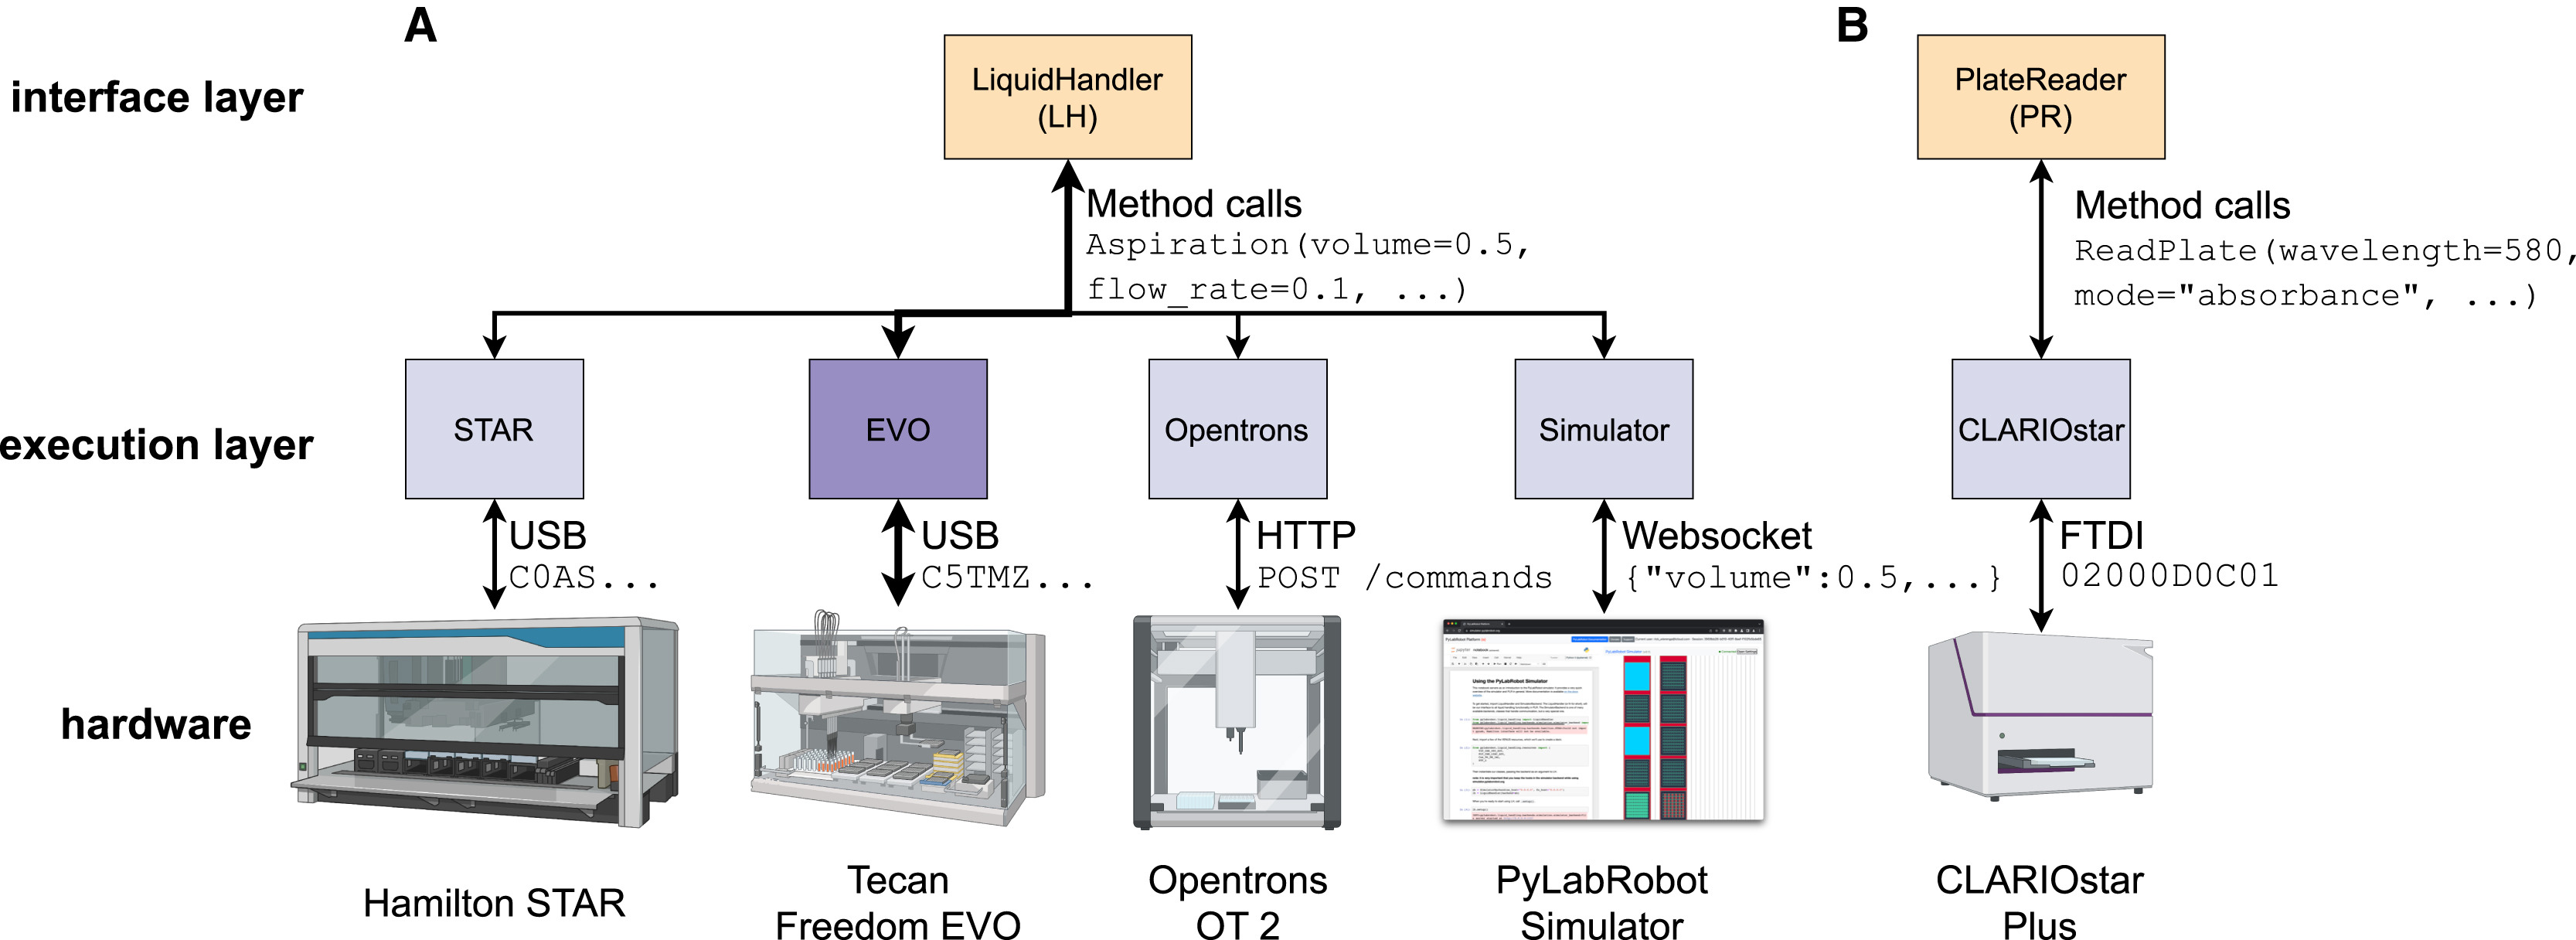


As we work through exercises and tutorials for PLR, make note of these specific help resources! Specifically, reading the **publication below** will help you get oriented with the organization of PLR. For more specific questions, reach out on the class **slack** or to the **TA** or **Professor** via email.

**PLR GitHub:** [Link](https://github.com/PyLabRobot/pylabrobot)

**PLR Forum:** [Link](https://discuss.pylabrobot.org/)

**Publication:** [Link](https://www.cell.com/device/fulltext/S2666-9986(23)00170-9)

### Getting Started
#### PLR Installation
To get started with PyLabRobot in a research environment, you should follow the [installation instructions](https://docs.pylabrobot.org/user_guide/_getting-started/installation.html) in the online documentation.

For BME 590, we recommend running these exercises locally through the install instructions on the [class GitHub](https://github.com/chory-lab/bme590-fall-2025/tree/main).

However, we are also beta-testing out these workshops via Google Colab and provide a forked version of PyLabRobot that has changes compatible with Google Colab to start the visualizer. To install, run the following code and then (**IMPORTANT**) go to **Runtime -> Restart Session** before continuing.

The reasons we do not currently recommend the Colab version:

1. We have not thoroughly tested all exercises throughout these notebooks.

2. Many features common in VS Code (such as the ability to search the PLR codebase) are not available in Colab, so you will need to have the PLR repo open in another tool (like VS Code or GitHub) to effectively look up documentation.

3. There are several code changes that are Colab-specific; the same code which works in Colab may not work in a research environment and vice-versa.

In [ ]:
%%capture
!git clone https://github.com/benjamin-perry-duke/pylabrobot.git && cd pylabrobot && pip install -e ".[dev]"

Let's go ahead and test your PLR installation. You should have an output that appears like:

```txt
Opentrons Version:  8.5.1
PLR Version:  0.1.6
```

In [ ]:
import pylabrobot.pylabrobot as pylabrobot
import opentrons
import asyncio # colab specific

print("Opentrons Version: ", opentrons.__version__)
print("PLR Version: ", pylabrobot.__version__)

# colab specific state tracker
active_instances = {
    "lh": None,
    "vis": None
}

#### Setting Up Your First Deck & Visualizer

Let's go ahead and set up your first deck for a liquid handler. To set up a liquid handler, you will need three things:

- **Liquid Handler Interface** - This is the top level class that will organize everything else for us.

- **A Deck Layout** - Different machines have different deck sizes/slots. The deck layout tells the LiquidHandler the geometric constraints of our robot.

- **A Backend** -- The backend does the heavy lifting of converting the instructions we write in Python to **machine code** tailored to each robot. Because we do not have a lab component to this class (yet), we must do our experimentation *virtually*. Fortunately, PLR has a built-in `Visualizer` class, which enables us to host a website locally that will display our active experiment as we work!

In the later workshops we will get into the specifics of setting up a deck, and different types of liquid handlers that are available through PLR. For now, we are just trying to make sure you can:

1. Setup a liquid handler deck.

2. Setup the visualizer.

3. Record a GIF of a basic protocol.

Let's start with setting up a deck. Run the following code to set up your first deck. Again, doon't worry about the following code; next week's workshop will cover it in detail.

In [ ]:
from pylabrobot.resources import (STARLetDeck, TIP_CAR_480_A00, PLT_CAR_L5AC_A00, Cor_96_wellplate_360ul_Fb, HTF)

async def make_deck_with_carriers_and_contents():
    deck = STARLetDeck()

    # create carriers
    tip_carrier = TIP_CAR_480_A00(name="awesome tip carrier 96x5")
    plate_carrier = PLT_CAR_L5AC_A00(name = "awesome plate carrier")

    # assign carriers
    deck.assign_child_resource(plate_carrier, rails = 5)
    deck.assign_child_resource(tip_carrier, rails = 11)

    # define 2 tip racks with unique names and assign to the first two slots of the tip carrier
    for i in range(3):
        tip_carrier[i] = HTF(name=f"tip_rack_{i}")

    # define 4 plates with unique names and assign to the first two slots of the plate carrier
    for i in range(4):
        plate_carrier[i] = Cor_96_wellplate_360ul_Fb(name=f"plate_{i}")

    return deck

deck = await make_deck_with_carriers_and_contents()

Great, you should now have a deck variable containing all the information of your first deck. Let's print a summary of this information.

In [ ]:
print(deck.summary())

Great! You should get an output that looks like this:


```txt
Rail  Resource                        Type           Coordinates (mm)
===================================================================================
(-6)  ├── trash_core96                Trash          (-58.200, 106.000, 229.000)
      │
(5)   ├── awesome plate carrier       PlateCarrier   (190.000, 063.000, 100.000)
      │   ├── plate_0                 Plate          (194.000, 071.500, 183.120)
      │   ├── plate_1                 Plate          (194.000, 167.500, 183.120)
      │   ├── plate_2                 Plate          (194.000, 263.500, 183.120)
      │   ├── plate_3                 Plate          (194.000, 359.500, 183.120)
      │   ├── <empty>
      │
(11)  ├── awesome tip carrier 96x5    TipCarrier     (325.000, 063.000, 100.000)
      │   ├── tip_rack_0              TipRack        (331.200, 073.000, 214.950)
      │   ├── tip_rack_1              TipRack        (331.200, 169.000, 214.950)
      │   ├── <empty>
      │   ├── <empty>
      │   ├── <empty>
      │
(31)  ├── waste_block                 Resource       (775.000, 115.000, 100.000)
      │   ├── teaching_tip_rack       TipRack        (780.900, 461.100, 100.000)
      │
(32)  ├── trash                       Trash          (800.000, 190.600, 137.100)
```

But this is kind of hard to actually visualize what is going on. To do that, let's setup our `Visualizer`

In [ ]:
from pylabrobot.resources import Deck
from pylabrobot.liquid_handling.backends.backend import LiquidHandlerBackend
from pylabrobot.liquid_handling.backends import LiquidHandlerChatterboxBackend
from pylabrobot.visualizer.visualizer import Visualizer
from pylabrobot.liquid_handling import LiquidHandler

# colab version requires state tracking
async def visualize_deck_colab(deck: Deck,
                         backend: LiquidHandlerBackend):

    # shut down old instances, if active
    if active_instances["vis"] is not None:
        print("stopping previous visualizer...")
        await active_instances["vis"].stop()
    if active_instances["lh"] is not None:
        print("stopping previous liquid handler...")
        await active_instances["lh"].stop()
        await asyncio.sleep(1)

    # create new lh and vis
    try:
        print("\nsetting up new liquid handler and visualizer...")
        lh = LiquidHandler(backend=backend, deck=deck)
        vis = Visualizer(resource=lh)
        await lh.setup()
        await vis.setup()

        # store states
        active_instances["lh"] = lh
        active_instances["vis"] = vis

        return lh, vis

    except Exception as e:
        print(f"An error occurred: {e}")
        active_instances["lh"] = None
        active_instances["vis"] = None
        return None, None

lh, vis = await visualize_deck_colab(deck, LiquidHandlerChatterboxBackend())

Running the above code should output something similar to:

```txt
Websocket server started at http://127.0.0.1:XXXX
File server started at http://127.0.0.1:XXXX . Open this URL in your browser.
```

This is effectively hosting a website at 127.0.0.1, which is the **localhost**, a special IP address that means the server is being hosted on your own machine. This means when you open the URL provided in the output, you are **connecting** to your own machine's server. You should see a chrome (or whatever default browser your machine has) tab open with an output that is similar to this:

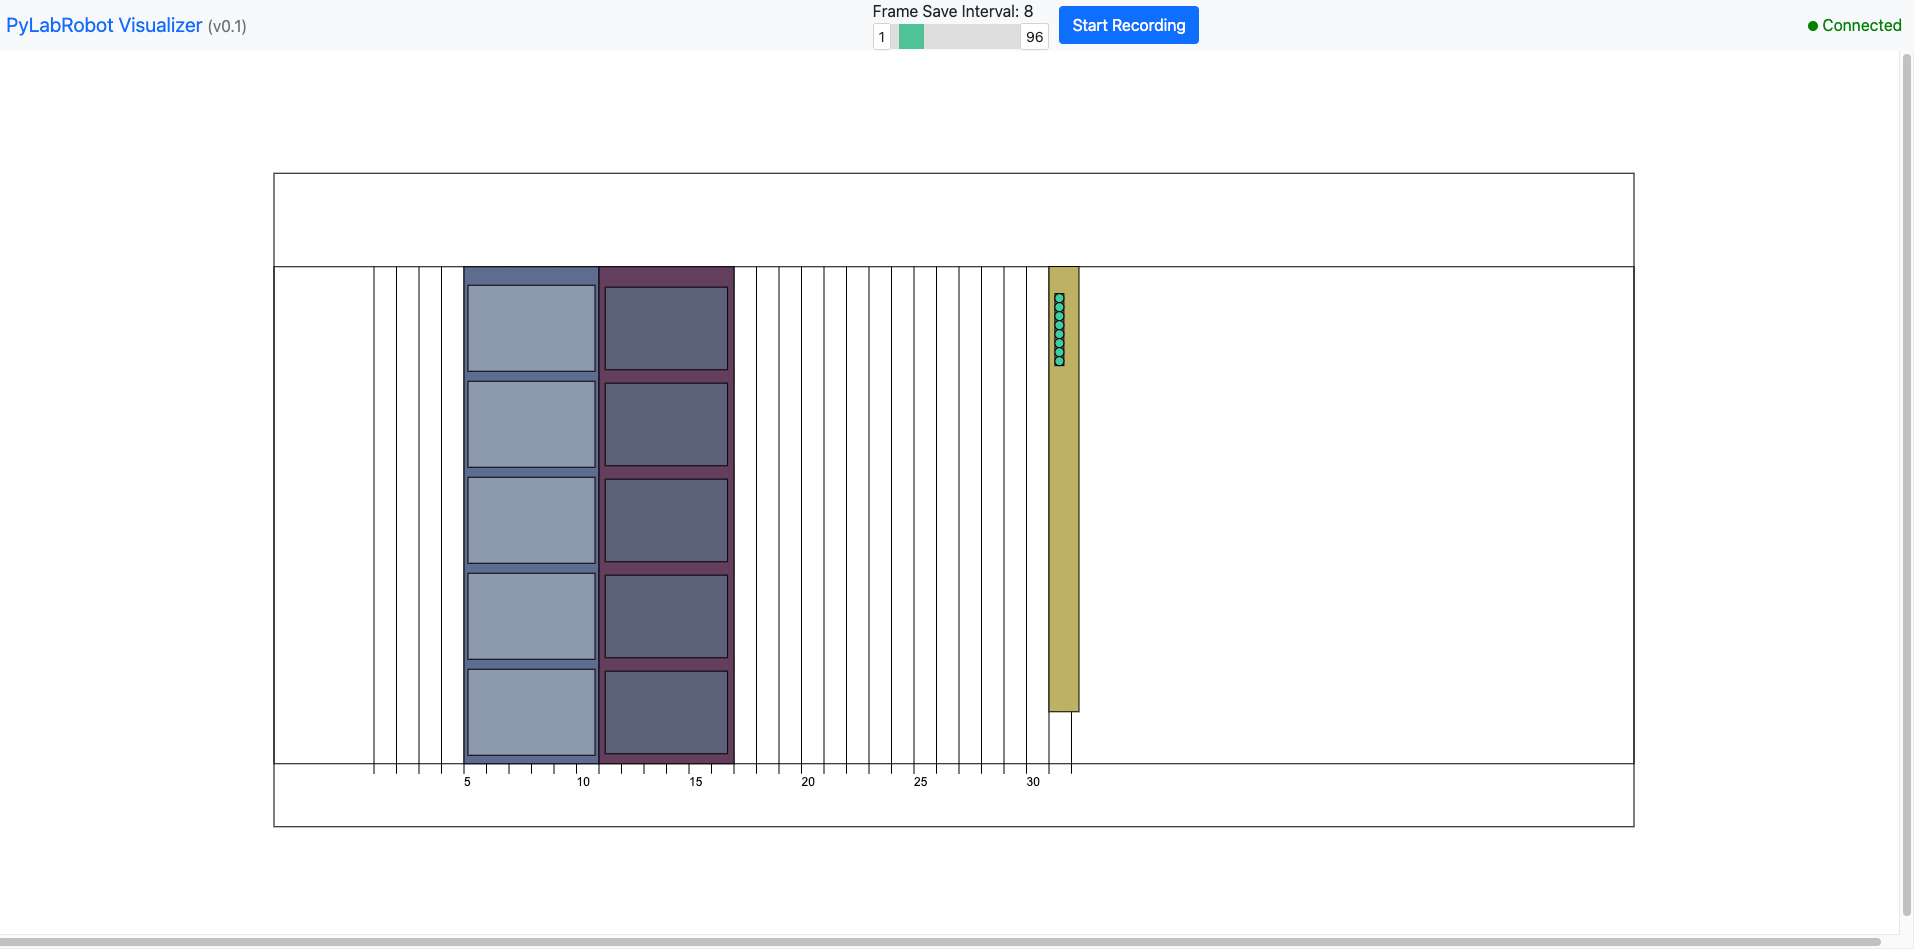

We aren't giving you the exact photo of the setup, because you will need to submit that as part of your assignment!

If a browser doesn't automatically open, simply **copy/paste** the output URL to your browser of choice.

The <span style="color:green"><strong>connected</strong></span> text in the top right corner of the visualizer indicates you are actively communicating with your local session. If for some reason this <span style="color:red"><strong>disconnects</strong></span>, the visualizer will need to be reset as it will lose track of any changes.

Congrats! Pylabrobot is working as expected!

---

**TO-DO:** Take a screenshot of your deck setup and save it to submit with the Workshop 0 assignment on Canvas.

---

#### Creating a GIF of a lab protocol

We kinda added everything at once there, but ideally, we would like to create a visualization of any lab protocol we use, **step-by-step**. The `Visualizer` allows us to do this pretty easily and this section will cover how to do that.

You may have noticed the **Start Recording** button at the top of the visualizer. When you press this button, it will record the **current state** of the visualized deck as a screenshot. Then, after any change to the deck, the recorder will capture **a new screenshot**.

These frames are then stitched together to form a final **GIF** of your lab protocol, which you can download through your browser! The key challenge is that you need to press **Start Recording** BEFORE any actions are taken by your code (such as pipetting, etc.)

The order of operations to achieve this is as follows:

1. Setup your initial deck and visualizer

2. Switch tabs to the visualizer and click **Start Recording**

3. Switch back to your code and execute the script for your protocol (just by running it)

4. Wait until the script has finished execution, then switch back to the visualizer and click **Stop Recording**

5. Enter a name for the `.gif` file and then click **Download GIF**.

6. Open your `.gif` file and verify it demonstrates your protocol correctly.

There are a couple of tips for success when working with the visualizer that we will share now:

1. Generally, it is good practice to work first without the visualizer as much as possible. The reason is because if an error occurs while you are using the visualizer, you may have to **reset** both the **deck** and **visualizer**. Every time the visualizer is reset, it will open a **new tab**, which can become annoying after several iterations.

    - It is also good to **functionalize your code** to have one function which **sets up your deck** and one which **runs the protocol**. Typically you will find most of your errors will occur in coding the protocol, so having a function to easily set up your deck again will **speed up your dvelopment**

    - We will cover this more in the deck setup tutorial.

2. You can visualize your protocol running in real time by doing the following:

    - Start the visualizer

    - Execute your protocol and switch back to the visualizer.

3. ...**however**, if you naively do this, you'll find that the entire code will run in the blink of an eye (and you won't be able to visualize anything)

    - It is best practice to introduce a **delay** between every step of your protocol.

    - This can simply by done with the `time.sleep(<duration_in_seconds>)` function in python's `time` module.

    - For the following deck setup code, we also include a `time.sleep(5)` function, which will sleep the script for **5 seconds** to give us time to open the visualizer and click **Start Recording** before the rest of the script runs.
    
    - If you need more time to click **Start Recording**, simply increase the duration of the sleep.

Ok, let's go ahead and give it a try below! Run the code, click the visualizer link, click **Start Recording** and watch your deck be setup in real time!

In [ ]:
import time

async def visualize_deck_with_time_delay(backend: LiquidHandlerBackend):

    # shut down old instances, if active
    if active_instances["vis"] is not None:
        print("stopping previous visualizer...")
        await active_instances["vis"].stop()
    if active_instances["lh"] is not None:
        print("stopping previous liquid handler...")
        await active_instances["lh"].stop()
        await asyncio.sleep(1)

    try:
        deck = STARLetDeck()
        lh = LiquidHandler(backend=backend, deck=deck)
        vis = Visualizer(resource = lh)

        # IMPORTANT CHANGE - Note this time we are setting up the visualizer first before adding stuff to our deck.
        await lh.setup()
        await vis.setup()
        time.sleep(5) # 5 second delay so we can open visualizer

        # create carriers
        tip_carrier = TIP_CAR_480_A00(name="awesome tip carrier 96x5")
        plate_carrier = PLT_CAR_L5AC_A00(name = "awesome plate carrier")

        # assign carriers
        deck.assign_child_resource(plate_carrier, rails = 5)
        time.sleep(0.5) # delay 0.5s
        deck.assign_child_resource(tip_carrier, rails = 11)
        time.sleep(0.5) # delay 0.5s

        # define 2 tip racks with unique names and assign to the first two slots of the tip carrier
        for i in range(3):
            tip_carrier[i] = HTF(name=f"tip_rack_{i}")
            time.sleep(0.5) # delay 0.5s

        # define 4 plates with unique names and assign to the first two slots of the plate carrier
        for i in range(4):
            plate_carrier[i] = Cor_96_wellplate_360ul_Fb(name=f"plate_{i}")
            time.sleep(0.5) # delay 0.5s

        # store states
        active_instances["lh"] = lh
        active_instances["vis"] = vis

        return lh, vis

    except Exception as e:
        print(f"An error occurred: {e}")
        active_instances["lh"] = None
        active_instances["vis"] = None
        return None, None

lh, vis = await visualize_deck_with_time_delay(LiquidHandlerChatterboxBackend())

If done correctly, the above code should create a **beautiful GIF**. Go ahead and click **Stop Recording**, name your file `lab_0_deck_setup.gif` and download it.

---

**TO-DO:** Download the GIF of your deck setup and save it to submit with the Workshop 0 assignment on Canvas.

---



#### Conclusion

That's all for workshop 0! As long as you were able to successfully download both a screenshot of your final deck setup and GIF, you should be good to go.

For the remainder of the workshops, we will cover more technical aspects of PLR, but in general, all of the assignments will require you to submit one or more of the following:

1. A `.gif` file of your protocol running.

2. A `.png` or `.jpeg` file of your initial deck setup or final deck setup.

3. A write-up describing your protocol, and any extensions thereof.

4. A `.ipynb`, `.py`, or `.txt` file with your final code to produce that protocol.

For this assignment, you just need to submit the `.png` file and the `.gif` file. If you are still feeling unsure on how to generate any of the following, please **reach out to the teaching team**, contact info for whom can be found in the .`README.md` file on the [class GitHub](https://github.com/chory-lab/bme590-fall-2025)

---